In [1]:
import torch
import matplotlib.pyplot as plt
import numpy
import sys
from torch.utils.data import Dataset, DataLoader
sys.path.insert(0, "..")
from classes.nn_classes import NNmodel

In [2]:
class Diffeq_model(NNmodel):
    def __init__(self, input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias=True) -> None:
        super().__init__(input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias)
    
    def forward(self, x):
        result = super().forward(x)
        return result, torch.autograd.grad(result, x, torch.ones_like(result), create_graph=True)[0]


def diff_eq1(x,y, x0=1.0, sigma=0.5):
    return 1.0/sigma**2*(x0-x)*y

In [3]:
def train_diff_model(diff_eq, model, train_loader, optimizer, 
                     epochs=500,
                     loss_func=torch.nn.MSELoss(), 
                     N_randoms=500,
                     x_max = 10.0,
                     x_min = 0.0,
                     gamma = 1.0,
                     ):
    train_losses = torch.zeros(epochs, 1)
    for epoch in range(epochs):
        model.train()
        for x_dat, y_dat in train_loader:
            x_deriv = (torch.rand(N_randoms)*(x_max - x_min) + x_min).view(-1,1)
            x_deriv.requires_grad = True
            optimizer.zero_grad()
            prediction, _ = model.forward(x_dat)
            loss = loss_func(prediction, y_dat)
            train_losses[epoch] += loss.item()*x_dat.size(0) 
            prediction, deriv_pred = model.forward(x_deriv)
            loss_deriv = gamma*loss_func(deriv_pred, diff_eq(x_deriv, prediction))
            loss+=loss_deriv
            train_losses[epoch] += loss_deriv.item() 
            loss.backward()
            optimizer.step()
    return train_losses

In [4]:
class MyCostumDataset(Dataset):
    def __init__(self, xs, ys) -> None:
        super().__init__()
        self.xs = xs
        self.ys = ys

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, index):
        return self.xs[index], self.ys[index]

In [5]:
xs = torch.tensor([1.0], dtype=torch.float, requires_grad=True).view(-1,1)
ys = torch.tensor([1.0], dtype=torch.float, requires_grad=True).view(-1,1)
train_data = MyCostumDataset(xs=xs, ys=ys)
train_loader = DataLoader(train_data)
dim_hiddens = [2,4,6,10,12]
models = [Diffeq_model(input_dim=1, output_dim=1, num_hidden_layers=1, dim_hiddens=dim_hidden, activation_func=torch.nn.SiLU()) for dim_hidden in dim_hiddens]

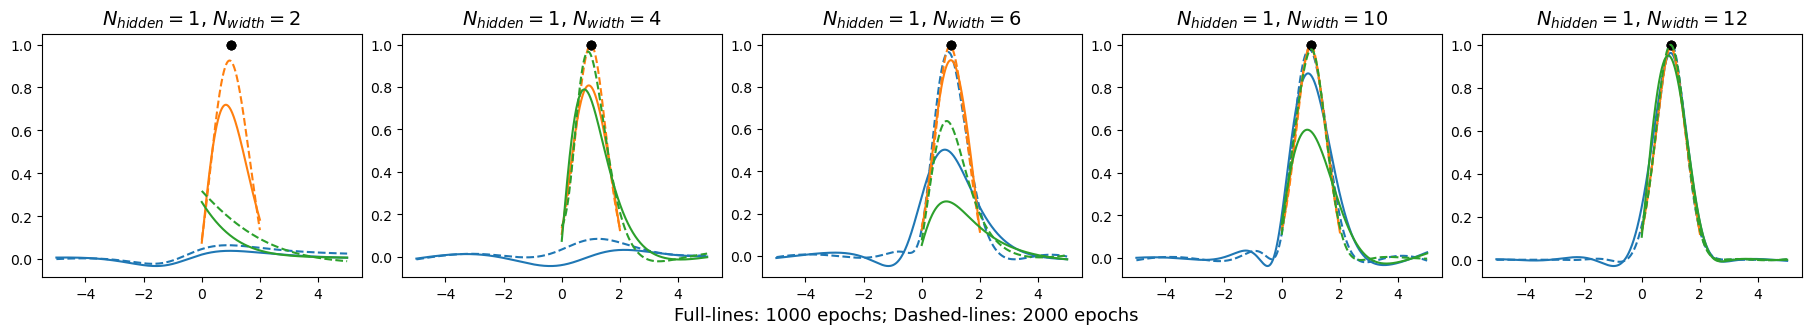

In [29]:
fig, axs = plt.subplots(1, 5, figsize=(18,3), layout="constrained")
dim_hiddens = [2,4,6,10,12]
x_ranges = [(-5.0, 5.0), (0.0,2.0), (0,5.0)]
colors = ["C0", "C1", "C2"]
for ax, dim_hidden in zip(axs, dim_hiddens):
    ax.set_title(r"$N_{hidden} = 1$, " + r"$N_{width} = $" + f"{dim_hidden}", fontsize=14)
    for x_range, color in zip(x_ranges, colors):
        model = Diffeq_model(input_dim=1, output_dim=1, num_hidden_layers=1, dim_hiddens=dim_hidden, activation_func=torch.nn.SiLU())
        optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
        xs = torch.linspace(x_range[0], x_range[1], 1000, requires_grad=True).view(-1,1)
        train_diff_model(diff_eq=diff_eq1, model=model, train_loader=train_loader, optimizer=optimizer, epochs=1000, x_max=x_range[1], x_min=x_range[0])
        prediction, _ = model.forward(xs)
        with torch.no_grad():
            ax.plot(xs, prediction, c=color)
            for x_dat, y_dat in train_loader:
                ax.plot(x_dat, y_dat, 'o', c="k")
        train_diff_model(diff_eq=diff_eq1, model=model, train_loader=train_loader, optimizer=optimizer, epochs=1000, x_max=x_range[1], x_min=x_range[0])
        prediction, _ = model.forward(xs)
        with torch.no_grad():
            ax.plot(xs, prediction, "--", c=color)

a = fig.text(0.5,-0.05,"Full-lines: 1000 epochs; Dashed-lines: 2000 epochs", fontsize=13, ha="center")

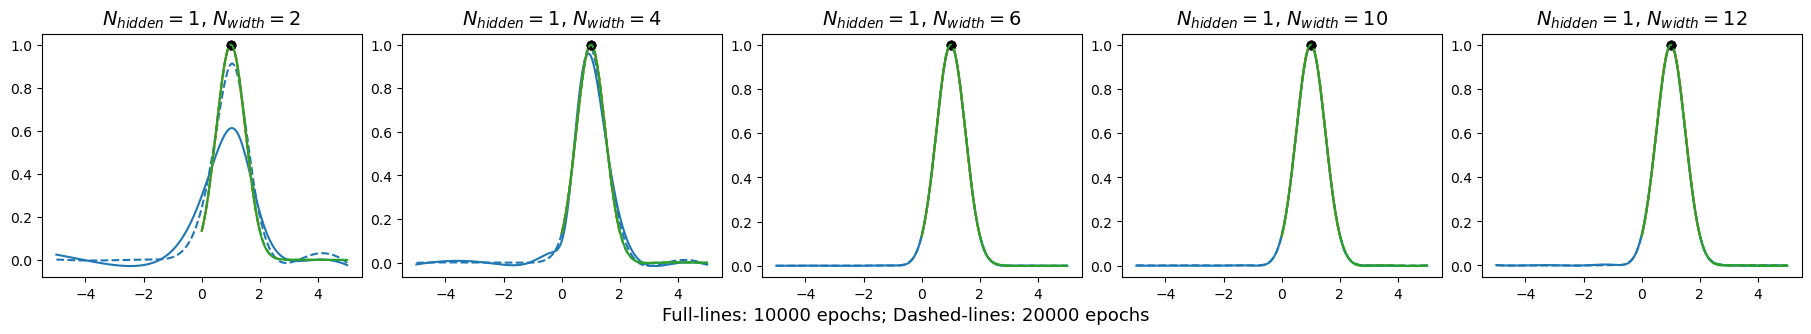

In [30]:
fig, axs = plt.subplots(1, 5, figsize=(18,3), layout="constrained")
dim_hiddens = [2,4,6,10,12]
x_ranges = [(-5.0, 5.0), (0.0,2.0), (0,5.0)]
colors = ["C0", "C1", "C2"]
for ax, dim_hidden in zip(axs, dim_hiddens):
    ax.set_title(r"$N_{hidden} = 1$, " + r"$N_{width} = $" + f"{dim_hidden}", fontsize=14)
    for x_range, color in zip(x_ranges, colors):
        model = Diffeq_model(input_dim=1, output_dim=1, num_hidden_layers=1, dim_hiddens=dim_hidden, activation_func=torch.nn.SiLU())
        optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
        xs = torch.linspace(x_range[0], x_range[1], 1000, requires_grad=True).view(-1,1)
        train_diff_model(diff_eq=diff_eq1, model=model, train_loader=train_loader, optimizer=optimizer, epochs=10000, x_max=x_range[1], x_min=x_range[0])
        prediction, _ = model.forward(xs)
        with torch.no_grad():
            ax.plot(xs, prediction, c=color)
            for x_dat, y_dat in train_loader:
                ax.plot(x_dat, y_dat, 'o', c="k")
        train_diff_model(diff_eq=diff_eq1, model=model, train_loader=train_loader, optimizer=optimizer, epochs=10000, x_max=x_range[1], x_min=x_range[0])
        prediction, _ = model.forward(xs)
        with torch.no_grad():
            ax.plot(xs, prediction, "--", c=color)

a = fig.text(0.5,-0.05,"Full-lines: 10000 epochs; Dashed-lines: 20000 epochs", fontsize=13, ha="center")

In [31]:
class Diffeq_model(NNmodel):
    def __init__(self, input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias=True) -> None:
        super().__init__(input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias)
    
    def forward(self, x):
        result = super().forward(x)
        deriv1 = torch.autograd.grad(result, x, torch.ones_like(result), create_graph=True)[0]
        deriv2 = torch.autograd.grad(deriv1, x, torch.ones_like(result), create_graph=True)[0]
        return result, deriv1, deriv2


def diff_eq2(x,y, dydx, sigma=0.5):
    return dydx**2/y - 1/sigma**2*y

def diff_eq3(x, y, dy2dx2, sigma=0.5):
    return dy2dx2*y +1.0/sigma**2*y**2

def train_diff_model(diff_eq, model, train_loader, optimizer, 
                     epochs=500,
                     loss_func=torch.nn.MSELoss(), 
                     N_randoms=200,
                     x_max = 10.0,
                     x_min = 0.0,
                     gamma = 1.0,
                     ):
    train_losses = torch.zeros(epochs, 1)
    for epoch in range(epochs):
        model.train()
        for x_dat, y_dat, y_deriv in train_loader:
            x_for_deriv = (torch.rand(N_randoms)*(x_max - x_min) + x_min).view(-1,1)
            x_for_deriv.requires_grad = True
            optimizer.zero_grad()
            prediction_y, prediction_deriv1, _ = model.forward(x_dat)
            loss = loss_func(prediction_y, y_dat) + gamma*loss_func(prediction_deriv1, y_deriv)
            train_losses[epoch] += loss.item()*x_dat.size(0)
            prediction_y, prediction_deriv1, prediction_deriv2 = model.forward(x_for_deriv)
            #loss_deriv = gamma*loss_func(prediction_deriv2, diff_eq(x_for_deriv, prediction_y, prediction_deriv1))
            loss_deriv = gamma*loss_func(prediction_deriv1**2, diff_eq(x_for_deriv, prediction_y, prediction_deriv2))
            loss+=loss_deriv
            train_losses[epoch] += loss_deriv.item() 
            loss.backward()
            optimizer.step()
    return train_losses


class MyCostumDataset(Dataset):
    def __init__(self, xs, ys, ys_deriv) -> None:
        super().__init__()
        self.xs = xs
        self.ys = ys
        self.ys_deriv = ys_deriv

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, index):
        return self.xs[index], self.ys[index], self.ys_deriv[index]


In [32]:
xs = torch.tensor([1.0], dtype=torch.float, requires_grad=True).view(-1,1)
ys = torch.tensor([1.0], dtype=torch.float, requires_grad=True).view(-1,1)
y_derivs = torch.tensor([0.0], dtype=torch.float, requires_grad=True).view(-1,1)
train_data = MyCostumDataset(xs=xs, ys=ys, ys_deriv=y_derivs)
train_loader = DataLoader(train_data)

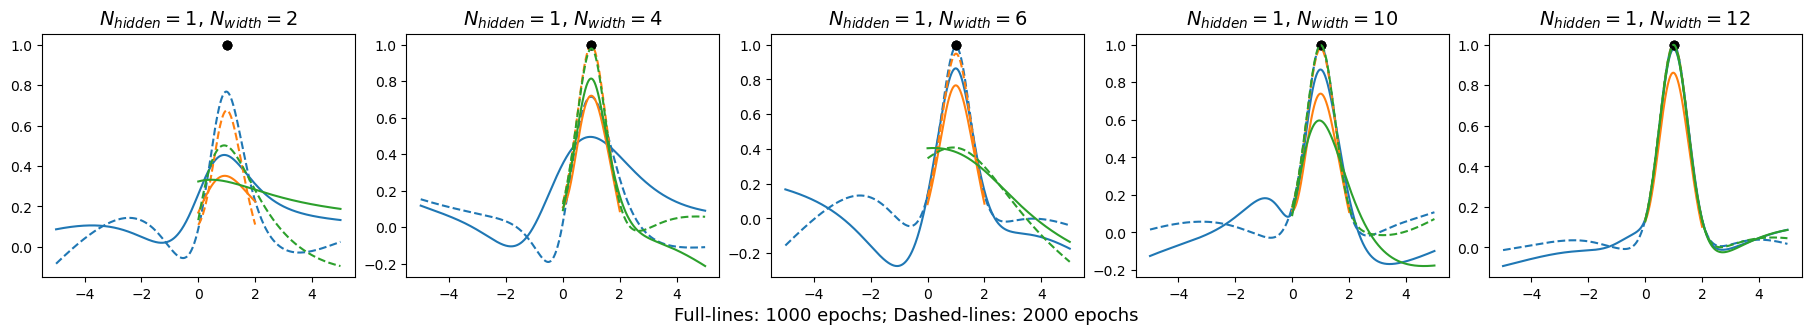

In [35]:
fig, axs = plt.subplots(1, 5, figsize=(18,3), layout="constrained")
dim_hiddens = [2,4,6,10,12]
x_ranges = [(-5.0, 5.0), (0.0,2.0), (0,5.0)]
colors = ["C0", "C1", "C2"]
for ax, dim_hidden in zip(axs, dim_hiddens):
    ax.set_title(r"$N_{hidden} = 1$, " + r"$N_{width} = $" + f"{dim_hidden}", fontsize=14)
    for x_range, color in zip(x_ranges, colors):
        model = Diffeq_model(input_dim=1, output_dim=1, num_hidden_layers=1, dim_hiddens=dim_hidden, activation_func=torch.nn.SiLU())
        optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
        xs = torch.linspace(x_range[0], x_range[1], 1000, requires_grad=True).view(-1,1)
        train_diff_model(diff_eq=diff_eq3, model=model, train_loader=train_loader, optimizer=optimizer, epochs=1000, x_max=x_range[1], x_min=x_range[0])
        prediction, _, _ = model.forward(xs)
        with torch.no_grad():
            ax.plot(xs, prediction, c=color)
            for x_dat, y_dat, _ in train_loader:
                ax.plot(x_dat, y_dat, 'o', c="k")
        train_diff_model(diff_eq=diff_eq3, model=model, train_loader=train_loader, optimizer=optimizer, epochs=1000, x_max=x_range[1], x_min=x_range[0])
        prediction, _, _ = model.forward(xs)
        with torch.no_grad():
            ax.plot(xs, prediction, "--", c=color)

a = fig.text(0.5,-0.05,"Full-lines: 1000 epochs; Dashed-lines: 2000 epochs", fontsize=13, ha="center")

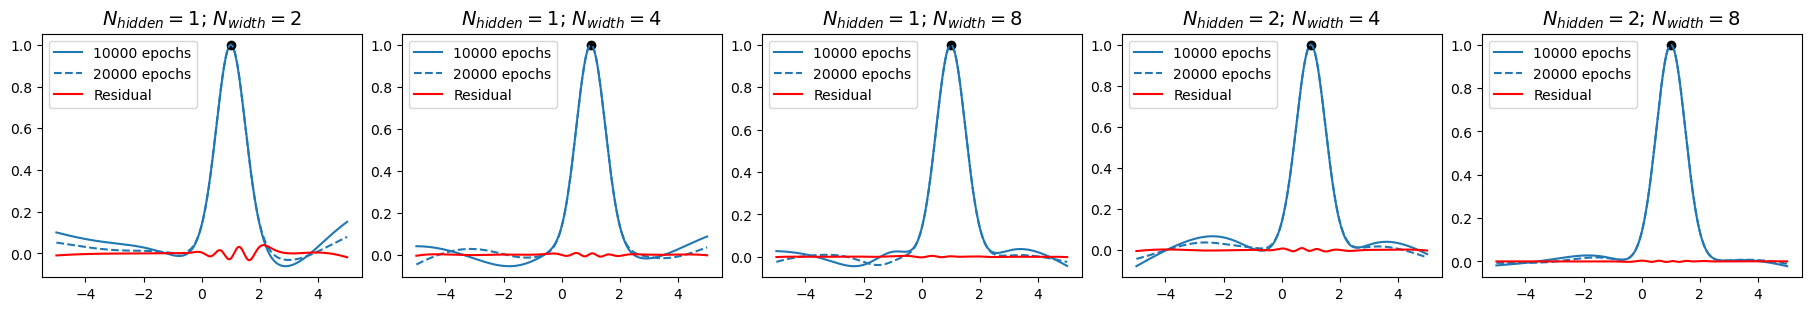

In [49]:
fig, axs = plt.subplots(1, 5, figsize=(18,3), layout="constrained")
dim_hiddens = [(1,2),(1,4),(1,8), (2,4),(2,8)]
x_ranges = [(-5.0, 5.0), (0.0,2.0), (0,5.0)]
colors = ["C0", "C1", "C2"]
for ax, dim_hidden in zip(axs, dim_hiddens):
    ax.set_title(r"$N_{hidden} = $"+f"{dim_hidden[0]}; " + r"$N_{width} = $" + f"{dim_hidden[1]}", fontsize=14)
    model = Diffeq_model(input_dim=1, output_dim=1, num_hidden_layers=dim_hidden[0], dim_hiddens=dim_hidden[1], activation_func=torch.nn.SiLU())
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    xs = torch.linspace(-5.0, 5.0, 1000, requires_grad=True).view(-1,1)
    train_diff_model(diff_eq=diff_eq3, model=model, train_loader=train_loader, optimizer=optimizer, epochs=10000, x_max=5.0, x_min=-5.0)
    prediction, _, _ = model.forward(xs)
    with torch.no_grad():
        ax.plot(xs, prediction, c="C0", label="10000 epochs")
        for x_dat, y_dat, _ in train_loader:
            ax.plot(x_dat, y_dat, 'o', c="k")
    train_diff_model(diff_eq=diff_eq3, model=model, train_loader=train_loader, optimizer=optimizer, epochs=10000, x_max=5.0, x_min=-5.0)
    prediction, dydx, d2yd2x = model.forward(xs)
    with torch.no_grad():
        ax.plot(xs, prediction, "--", c="C0", label="20000 epochs")
        ax.plot(xs, dydx**2 - diff_eq3(xs, prediction, d2yd2x), c="red", label="Residual")
    ax.legend()


In [84]:
xs = torch.tensor([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0], dtype=torch.float, requires_grad=True).view(-1,1)
ys = torch.tensor([0.5, 0.5, 1.0, -0.5, 0.5, -0.5, 0.5], dtype=torch.float, requires_grad=True).view(-1,1)
y_derivs = torch.tensor([2.0, -2.0, 2.0, -2.0, 2.0, -2.0, 2.0], dtype=torch.float, requires_grad=True).view(-1,1)
train_data = MyCostumDataset(xs=xs, ys=ys, ys_deriv=y_derivs)
train_loader = DataLoader(train_data, batch_size=2)

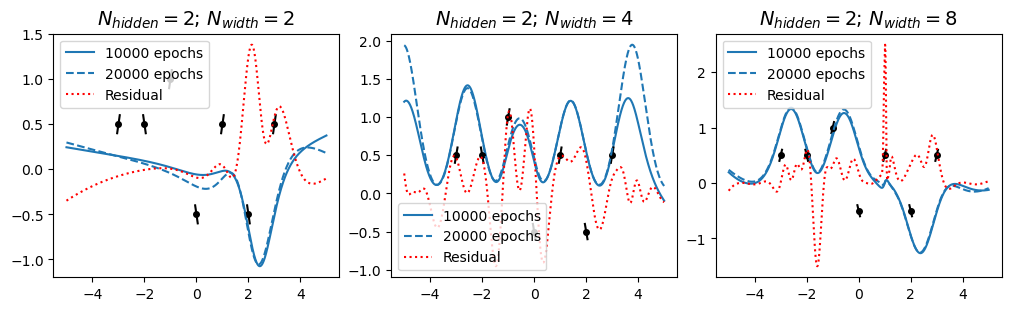

In [85]:
def tangent(x0, y0, dydx, xs=torch.linspace(-0.5, 0.5, 50)):
    return (xs-x0)*dydx + y0

fig, axs = plt.subplots(1, 3, figsize=(10,3), layout="constrained")
dim_hiddens = [(2,2),(2,4),(2,8)]
colors = ["C0", "C1", "C2"]
for ax, dim_hidden in zip(axs, dim_hiddens):
    ax.set_title(r"$N_{hidden} = $"+f"{dim_hidden[0]}; " + r"$N_{width} = $" + f"{dim_hidden[1]}", fontsize=14)
    model = Diffeq_model(input_dim=1, output_dim=1, num_hidden_layers=dim_hidden[0], dim_hiddens=dim_hidden[1], activation_func=torch.nn.SiLU())
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    xs = torch.linspace(-5.0, 5.0, 1000, requires_grad=True).view(-1,1)
    train_diff_model(diff_eq=diff_eq3, model=model, train_loader=train_loader, optimizer=optimizer, epochs=10000, x_max=5.0, x_min=-5.0, N_randoms=32)
    prediction, _, _ = model.forward(xs)
    with torch.no_grad():
        ax.plot(xs, prediction, c="C0", label="10000 epochs")
        for x_dat, y_dat, y_deriv_dat in train_loader:
            ax.plot(x_dat, y_dat, 'o', c="k", ms=4)
            for x_point, y_point, y_deriv in zip(x_dat, y_dat, y_deriv_dat):
                xs_tang = torch.linspace(-0.05, 0.05, 50) + x_point
                ax.plot(xs_tang, tangent(x0=x_point, y0=y_point, dydx=y_deriv, xs=xs_tang), c="k")
    train_diff_model(diff_eq=diff_eq3, model=model, train_loader=train_loader, optimizer=optimizer, epochs=10000, x_max=5.0, x_min=-5.0, N_randoms=32)
    prediction, dydx, d2yd2x = model.forward(xs)
    with torch.no_grad():
        ax.plot(xs, prediction, "--", c="C0", label="20000 epochs")
        ax.plot(xs, dydx**2 - diff_eq3(xs, prediction, d2yd2x), c="red", label="Residual", ls=":")
    ax.legend()
